In [1]:
import pandas as pd
import os
from glob import glob
import warnings
import random
warnings.filterwarnings('ignore')
import datetime

import import_ipynb
import abuse_detecting_preprocessing as pp
import abuse_detecting_databuild as b

import pandas as pd
import numpy as np

import fasttext

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

if os.name == 'posix':
    sns.set(font = "AppleGothic")
elif os.name == 'nt':
    sns.set(font = "Malgun Gothic")
%config InlineBackend.figure_format = 'retina'

_1DCNN_model = tf.keras.models.load_model('1DCNN_model.h5')
BiLSTM_model = tf.keras.models.load_model('BiLSTM_model.h5')
GRU_model = tf.keras.models.load_model('GRU_model.h5')
fasttext_model = fasttext.load_model('/Users/kim-yongjun/Documents/abuse_detecting/fasttext_model.bin')


importing Jupyter notebook from abuse_detecting_preprocessing.ipynb
['ㅇㅡㄴㄹㅡㄹㅈㅏㄹㅇㅣ-ㄱㅣㄴㄷㅏ-ㅎㅏ-', 'ㄴㅡㄴㄹㅗㄹㅇㅢ-ㅅㅣㄴㅇㅣ-ㄷㅏ-'] 

['t1ㅇㅡㄴlckㄹㅡㄹㅈㅏㄹㅇㅣ-ㄱㅣㄴㄷㅏ-ㅎㅏ-', 'fakerㄴㅡㄴㄹㅗㄹㅇㅢ-ㅅㅣㄴㅇㅣ-ㄷㅏ-'] 

importing Jupyter notebook from abuse_detecting_databuild.ipynb


In [84]:
N = 5
_input = 40 # 단어 길이
input_shape = (_input, 100)
def soft_ensemble(messages):
    models = [_1DCNN_model, BiLSTM_model, GRU_model]
    vec = b.making_x_train(messages, input_, fasttext_model, N)
    pred = np.column_stack([m.predict(vec, verbose = 0) for m in models]) # verbose = 0으로 설정하여 predict
                                                                          # 진행창을 안보이도록 설정
    ensembled_pred = np.round(np.mean(pred, axis = 1))
    return ensembled_pred

In [83]:
routes = glob(os.getcwd() + '/chatting_datas/*.csv')
teams = {'T1' : [], 'GEN' : [], 'HLE' : [], 'KT' : [], 'KDF' : [],
         'DK' : [], 'FOX' : [], 'NS' : [], 'DRX' : [], 'BRO' : []}

for route in routes: # 채팅 데이터중 각 팀의 이름이 들어간 경기들을 모은다.
    for team in teams:
        if route.find(team) != -1:
            teams[team].append(route)

In [15]:
def makesample():
    # 모든 데이터의 욕설 수를 세기에는 너무 양이 많고 수가 달라 10000개씩 sampling 함.
    teams_pred = {'T1' : None, 'GEN' : None, 'HLE' : None, 'KT' : None, 'KDF' : None,
                  'DK' : None, 'FOX' : None, 'NS' : None, 'DRX' : None, 'BRO' : None}
    for team in teams:
        df = pd.DataFrame()
        for r in teams[team]:
            d = pd.read_csv(r)
            df = pd.concat([df,d], axis = 0, ignore_index = True)
        message = df['message'].dropna()
        sample = message.sample(10000)
        pred = soft_ensemble(sample)
        team_df = pd.DataFrame({'message' : sample, 'label' : pred})
        teams_pred[team] = team_df
        
    df_counts = {'team' : [], '욕설 수' : []}
    for team in teams_pred:
        df_counts['team'].append(team)
        df_counts['욕설 수'].append(teams_pred[team]['label'].value_counts()[0])
    df_counts = pd.DataFrame(df_counts)
    df_counts = df_counts.sort_values(by = '욕설 수', ascending = False)        
    return teams_pred, df_counts.reset_index(drop = True)
    

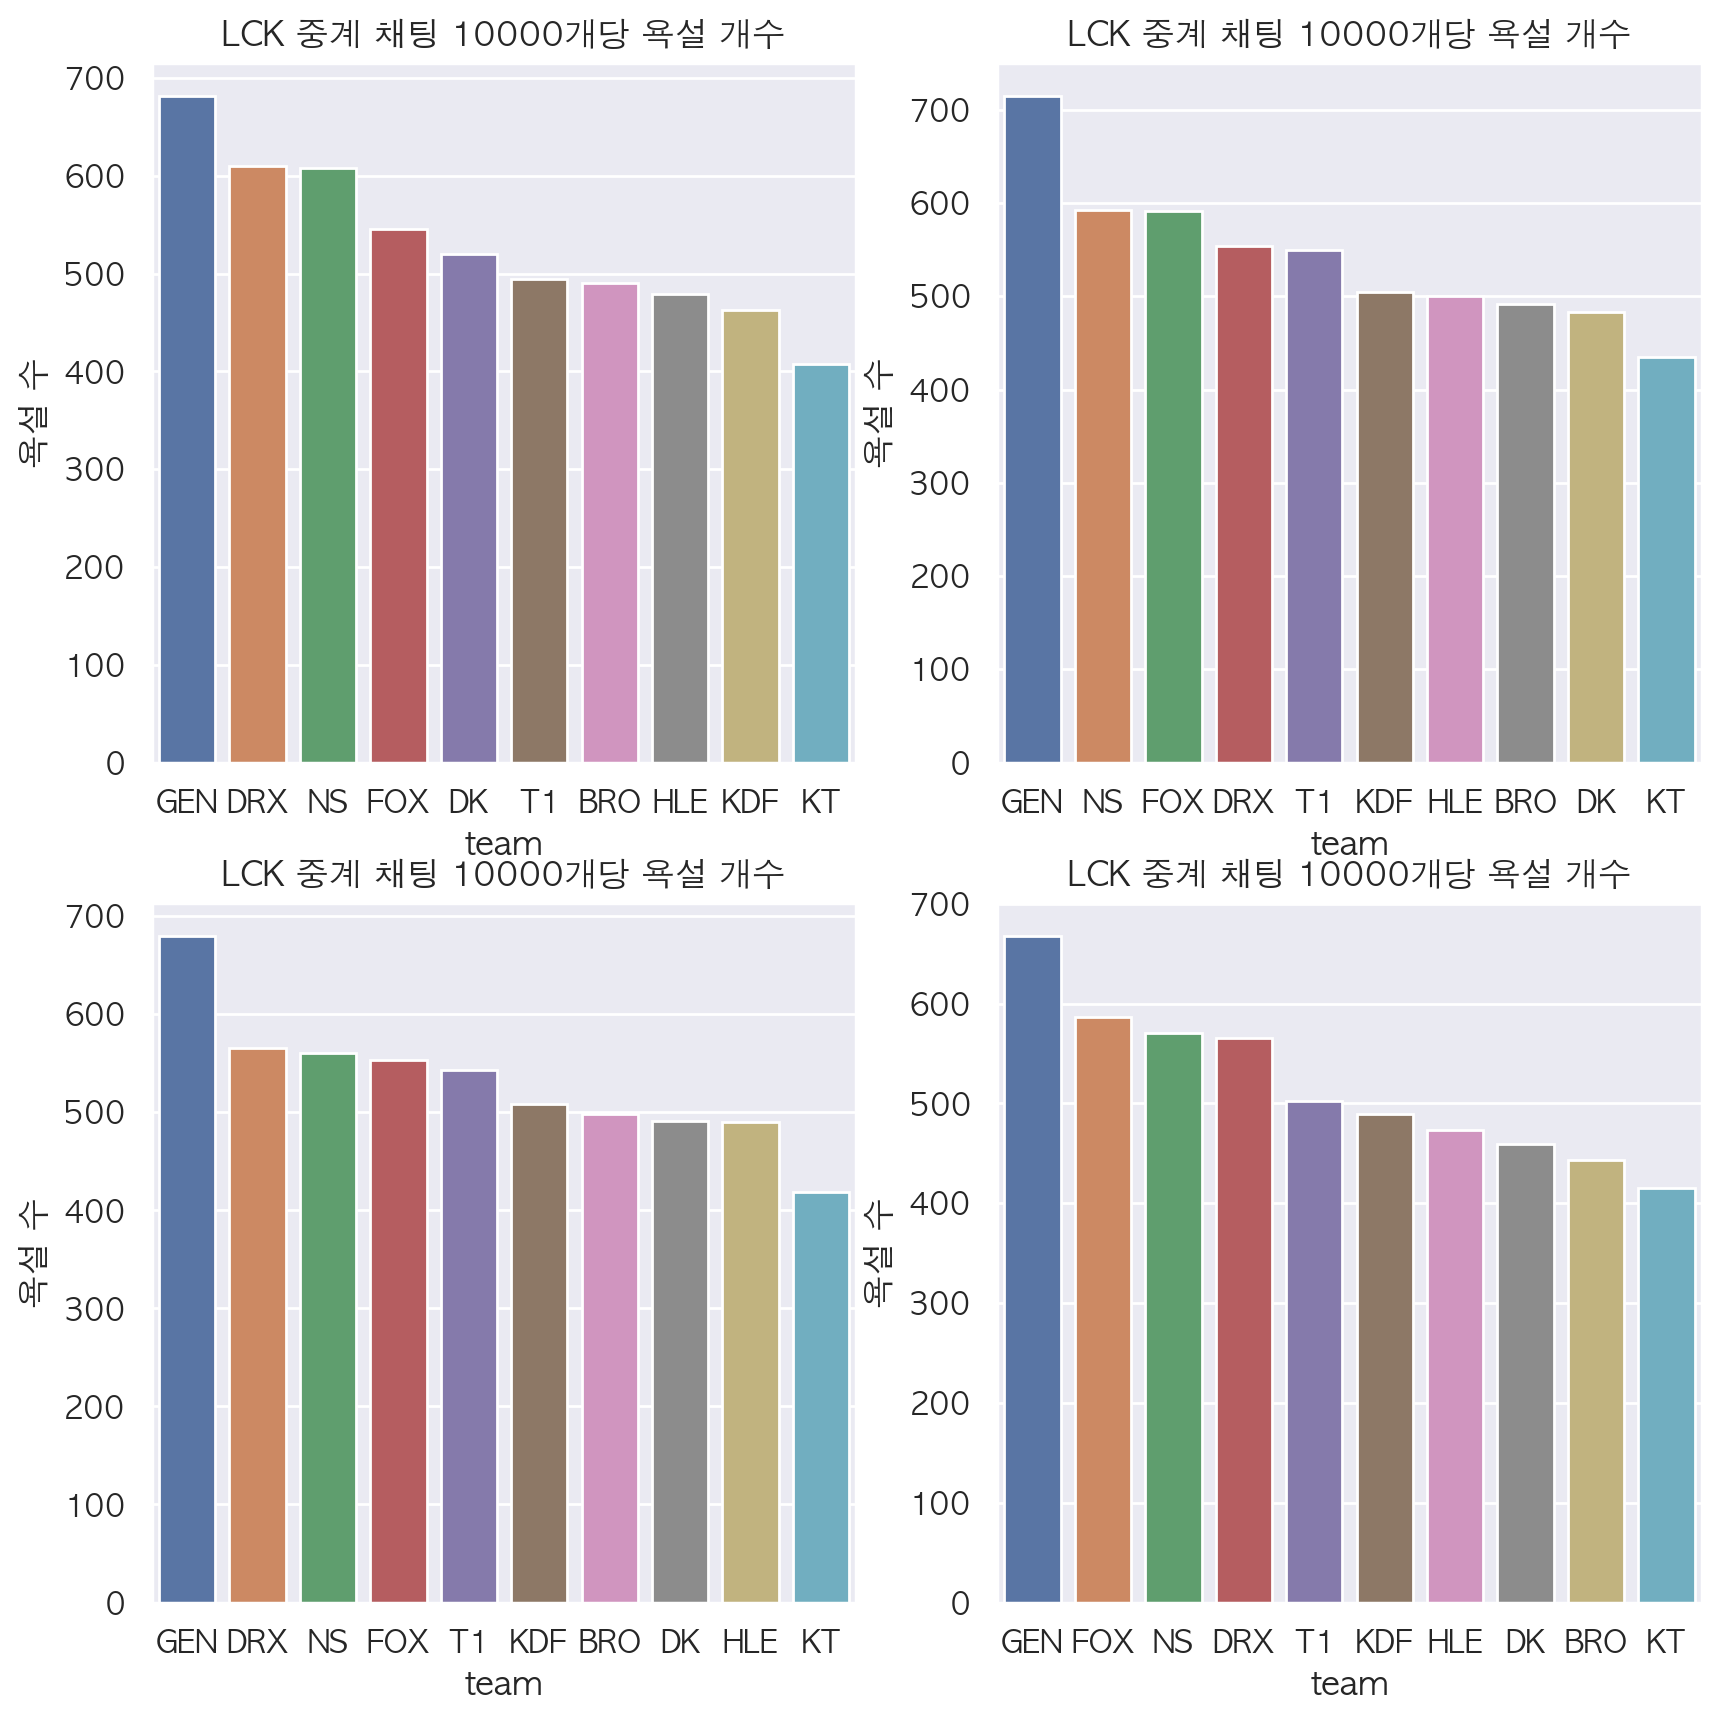

In [16]:
fig, axes = plt.subplots(2,2, figsize = (10, 10))
for i in range(4):
    row = i // 2 # 0 0 1 1
    col = i % 2  # 0 1 0 1
    teams_pred, df_sample = makesample()
    sns.barplot(x = 'team', data = df_sample, y = '욕설 수', hue = 'team', ax = axes[row, col])
    axes[row, col].set_title('LCK 중계 채팅 10000개당 욕설 개수')


10000개씩 샘플을 뽑아 욕설 개수를 계산해 봤는데, 몇번을 시행해도 GEN가 1등, KT가 10등이었다.
하지만 모델이 88848,쵸쵸쵸룰쵸, 888룰8 등을 욕설로 너무 확실히 잡다 보니, 젠지에 관한 욕설만 많이 잡히는 듯 싶다.
(근데 또 그거를 제외하면 생각보다 욕설이 적다.)
T1 경기에 욕설이 가장 많을 줄 알았으나, 티원 경기는 의외로 욕설양이 적었다.
T1 팬들이 젠지에 대한 욕설을 젠지 경기가 아닌 다른 경기에서도 많이 하는 듯 하다. 
다른 경기에서도 대부분의 욕설은 젠지를 비꼬는 욕설들이었다.


In [81]:
teams_pred['GEN'][teams_pred['GEN']['label'] == 0].sample(20)

,message,label
80671,젠도스 젠도스 신나는 노래,0.0
381662,젠지 짜요,0.0
184229,국제전 무관 젠지 ㄷㄷ,0.0
363947,불공정한 연습기회 운운하며 승자를 존중하지 못하는 그선수에 그팬분들 ㅋㅋㅋ 제발 님...,0.0
379550,체력 1577 이러네 지능이 낮긴 낮어 ㅋㅋㅋ,0.0
360180,88848이 뭔데 왜자꾸 유튜브채팅방에 88848 도배하는건가요? 88848이라고 ...,0.0
263603,슼갈들 젠지한테 발리니까 이악물고 지길바라다가 긁힘 ㅋㅋㅋㅋ,0.0
13723,88848,0.0
279705,88848,0.0
359234,1 5 5 7 8 8 8 4 8,0.0


In [82]:
teams_pred['GEN'][teams_pred['GEN']['label'] == 1].sample(20)

,message,label
22229,결국 쵸비가 캐리함 ㅋㅋ,1.0
233204,너무잘하는데,1.0
248455,아오 낀낀이형ㅋㅋㅋ,1.0
83373,커즈잖아,1.0
35173,ㅋㅋㅋㅋ 원딜망겜ㅋㅋㅋㅋㅋㅋ,1.0
131173,대 리 아,1.0
10434,엄크떳다,1.0
369307,결국 아지르 밴 안해서 ㅋㅋ,1.0
299399,윤수빈아나운서 팬미팅있으면 가고싶어요~~~ 계속 인터뷰장면 돌려보게되네여 사랑스럽고...,1.0
284017,전맵 kt가 장악중이네,1.0
